In [ ]:
# Import Libraries
import torch
from torch import nn, optim

# torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import Others
import matplotlib.pyplot as plt
import numpy as np
from time import time
from tqdm.auto import tqdm
import random

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.0.1+cu118
0.15.2+cu118


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Load MNIST
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 9912422/9912422 [00:00<00:00, 117801912.69it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 83657247.12it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34626202.36it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 601570.32it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


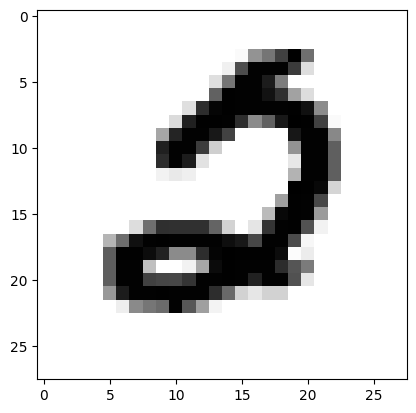

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

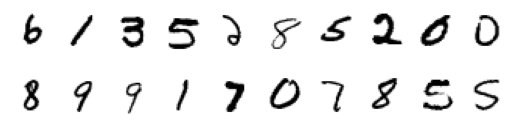

In [ ]:
num_images = 20
for i in range(1, num_images + 1):
    plt.subplot(6, 10, i)
    plt.axis('off')
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')

In [ ]:
class MNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
# Setup model with input params
model_0 = MNISTModelV0(
    input_shape = 784, # 28*28
    hidden_units= 64,
    output_shape = 10 # one for every class
).to(device)

model_0

MNISTModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time"""
  total_time = end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:

def train_test_loop(epochs, model):
  train_time_start_on_cpu = timer()
  for e in tqdm(range(epochs)):
    train_loss = 0
    for batch, (images, labels) in enumerate(train_loader):

      # Put on Target Device
      images, labels = images.to(device), labels.to(device)

      # Flatten MNIST images into a 784 long vector
      images = images.view(images.shape[0], -1)

      # Forward Pass
      image_prediction = model(images)

      # Calculate Loss
      loss = loss_fn(image_prediction, labels)
      train_loss += loss_fn(image_prediction, labels)

      # Optimizer Zero Grad
      optimizer.zero_grad()

      # Loss Backward
      loss.backward()

      # Optimizer Step
      optimizer.step()

      # Printing
      if batch % 200 == 0:
        print(f"Looked at {batch * len(images)}/{len(train_loader.dataset)} samples.")

    train_loss /= len(train_loader)

    # Testing
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
      for images_test, labels_test in test_loader:

        # Put on Target Device
        images_test, labels_test = images_test.to(device), labels_test.to(device)

        # Flatten MNIST images into a 784 long vector
        images_test = images_test.view(images_test.shape[0], -1)

        # 1. Forward Pass
        test_prediction = model(images_test)

        # 2. Calculate Loss
        test_loss += loss_fn(test_prediction, labels_test)

        # 3. Calculate Accuracy
        test_acc += accuracy_fn(y_true=labels_test, y_pred=test_prediction.argmax(dim=1))

      # Calculate the test loss and accuracy averages
      test_loss /= len(test_loader)
      test_acc /= len(test_loader)

    # Printing
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  # Calculate training time
  train_time_end_on_cpu = timer()
  total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))



In [ ]:
epochs = 5
model = model_0

train_test_loop(epochs, model)

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.51426 | Test loss: 0.24865, Test acc: 92.54%

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.20294 | Test loss: 0.16637, Test acc: 95.02%

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.14276 | Test loss: 0.14525, Test acc: 95.45%

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.11130 | Test loss: 0.11608, Test acc: 96.37%

Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.



In [ ]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

Predicted Digit = 4
Actual Digit = 4


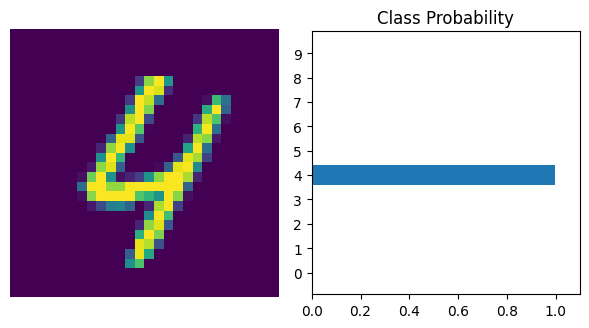

In [ ]:
images, labels = next(iter(test_loader))
r = random.randint(0, 64-1)

img = images[r].view(1, 784).to(device)
with torch.no_grad():
    logps = model_0(img)

ps = torch.exp(logps)
probab = list(ps.cpu().numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
print("Actual Digit =", labels[r].numpy())
view_classify(img.cpu().view(1, 28, 28), ps.cpu())